In [27]:
import sys
import os
import logging
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Iterator

from transformers import AutoTokenizer

from docling.document_converter import DocumentConverter
from docling.document_converter import PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.datamodel.pipeline_options import TableFormerMode

from docling_core.types.doc.base import ImageRefMode
from docling_core.types.doc.document import PictureItem
from docling_core.types.doc.document import TableItem
from docling_core.types.doc.document import TextItem
from docling_core.types.doc.document import DoclingDocument
from docling_core.transforms.chunker.tokenizer.base import BaseTokenizer
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from docling_core.transforms.chunker.base import BaseChunker
from docling_core.transforms.chunker.base import BaseChunk
from docling_core.transforms.chunker.hierarchical_chunker import HierarchicalChunker
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling.backend.docling_parse_v4_backend import DoclingParseV4DocumentBackend
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend

pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE
pipeline_options.do_code_enrichment = True
pipeline_options.do_formula_enrichment = True
pipeline_options.do_picture_classification = True
pipeline_options.generate_picture_images = True

converter = DocumentConverter(
    allowed_formats = [InputFormat.PDF],
    format_options = {
        InputFormat.PDF: PdfFormatOption(pipeline_options = pipeline_options, backend = PyPdfiumDocumentBackend),
        }
    )

logging.basicConfig(level = logging.INFO)

output_dir = Path('Output')
output_dir.mkdir(exist_ok = True)

In [20]:
#docling_paper = 'https://arxiv.org/pdf/2501.17887'
sample_doc_url = 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf'

result = converter.convert(sample_doc_url)
doc = result.document

2025-11-06 21:34:05,477 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-06 21:34:05,484 - INFO - Going to convert document batch...
2025-11-06 21:34:05,484 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 856a3ad2045bfefde9d0b466c79fde17
2025-11-06 21:34:05,484 - INFO - Accelerator device: 'cuda:0'
2025-11-06 21:34:05,804 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-11-06 21:34:05,805 - INFO - easyocr cannot be used because it is not installed.
2025-11-06 21:34:05,806 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-11-06 21:34:05,814 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-11-06 21:34:05,823 [RapidOCR] download_file.py:60: File exists and is valid: /home/torben/Huginn/.venv/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-11-06 21:34:05,823 [RapidOCR] torch.py:54: Using /home/torben/Huginn/.venv/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.p

In [21]:
md_out = doc.export_to_markdown()
print(f'{md_out[ : 2000]}')

<!-- image -->

## ANNUAL REPORT 2020

<!-- image -->

bridging the gap between poverty and prosperity

<!-- image -->

## A message from Co-Founder, President, and CEO, David Kieser

No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.

All MFB locations remained open and responsive to the need of our nonprofit partners. We enacted safety protocols and reduced volunteer numbers to maintain social distancing guidelines. To allow partner agencies to receive food from MFB safely, we altered our distribution model. Community, business, and donor support funded operations and helped with food purchases. More details on our response to the pandemic are on page 14.

Noteworthy in 2020:

- MFB distributed a record amount of food, 37% more than in 2019.
- In 2020, we sent a record number of family f

In [22]:
print(f"Document title: {doc.name}")
print(f"Number of pages: {len(doc.pages)}")
print(f"Number of tables: {len(doc.tables)}")
print(f"Number of pictures: {len(doc.pictures)}")

print('Document structure')
for i, (item, level) in enumerate(doc.iterate_items()):
    if i < 20:
        item_type = type(item).__name__
        text_preview = item.text[:200] if hasattr(item, 'text') else 'N/A'
        print(f'{"  " * level}- {item_type}: {text_preview}')

    

Document title: AR_2020_WEB2
Number of pages: 20
Number of tables: 2
Number of pictures: 53
Document structure
  - PictureItem: N/A
  - SectionHeaderItem: ANNUAL REPORT 2020
  - PictureItem: N/A
  - TextItem: bridging the gap between poverty and prosperity
  - PictureItem: N/A
  - SectionHeaderItem: A message from Co-Founder, President, and CEO, David Kieser
  - TextItem: No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Foo
  - TextItem: All MFB locations remained open and responsive to the need of our nonprofit partners. We enacted safety protocols and reduced volunteer numbers to maintain social distancing guidelines. To allow partn
  - TextItem: Noteworthy in 2020:
    - ListItem: MFB distributed a record amount of food, 37% more than in 2019.
    - ListItem: In 2020, we sent a record number of family food boxes in Disaster Relief semi l

In [23]:
#doc.save_as_json(output_dir / 'docling_paper.json')
doc.save_as_json(output_dir / 'annual_report.json')


In [24]:
def visualize_chunks(chunks: list[BaseChunk], *, chunker: BaseChunker, tokenizer: BaseTokenizer, title = 'Document Chunks'):
    """Visualize chunk sizes and distributions in tokens.
    """

    token_counts = [tokenizer.count_tokens(chunker.contextualize(chunk = chunk)) for chunk in chunks]

    plt.figure(figsize = (10, 6))
    plt.hist(token_counts, bins = 20, alpha = 0.7, color = 'skyblue')
    avg_tokens = float(np.mean(token_counts))
    plt.axvline(avg_tokens, color = 'red', linestyle = '--', label = f'Average Tokens: {avg_tokens:.1f}')
    plt.title(title)
    plt.xlabel('Chunk Size (Tokens)')
    plt.ylabel('Frequency')
    plt.grid(axis = 'y', alpha = 0.75)
    plt.legend()
    plt.show()

    print(f'Chunk Analysis Results:')
    print(f'Total chunks: {len(token_counts)}')
    print(f'Average chunk size: {np.mean(token_counts):.1f} tokens')
    print(f'Minimum chunk size: {min(token_counts)} tokens')
    print(f'Maximum chunk size: {max(token_counts)} tokens')
    print(f'Standard deviation: {float(np.std(token_counts)):.1f} tokens')

    if max(token_counts) > 512:
        print('Warning: Some chunks exceed 512 tokens - consider reducing chunk size')
    if np.std(token_counts) > 100:
        print('Warning: High variability in chunk sizes - retrieval consistency may suffer')

    char_lengths = [len(chunk.text) for chunk in chunks]
    print(f'\nReference - Average character length per chunk: {np.mean(char_lengths):.1f} characters')

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Generated 161 hierarchical chunks with HierarchicalChunker


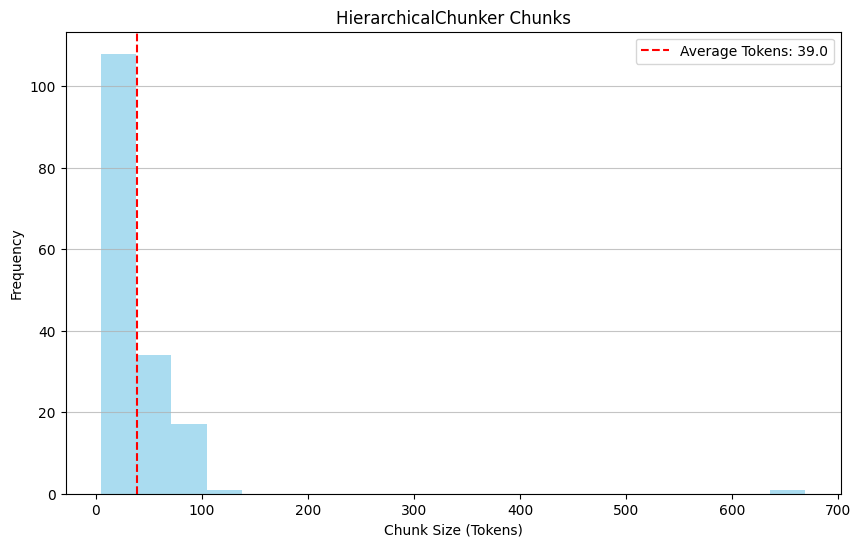

Chunk Analysis Results:
Total chunks: 161
Average chunk size: 39.0 tokens
Minimum chunk size: 5 tokens
Maximum chunk size: 669 tokens
Standard deviation: 55.5 tokens

Reference - Average character length per chunk: 132.4 characters


In [26]:
embeddings_model_path = 'ibm-granite/granite-embedding-30m-english'
hf_token = os.getenv('HUGGING_FACE_HUB_TOKEN')
embeddings_tokenizer = HuggingFaceTokenizer(tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path, token = hf_token))
hierarchical_chunker = HierarchicalChunker()
hierarchical_chunks = list(hierarchical_chunker.chunk(doc))

print(f'Generated {len(hierarchical_chunks)} hierarchical chunks with HierarchicalChunker')
visualize_chunks(
    chunks = hierarchical_chunks,
    title = 'HierarchicalChunker Chunks',
    chunker = hierarchical_chunker,
    tokenizer = embeddings_tokenizer
    )


HybridChunker Results: 
Generated 73 chunks


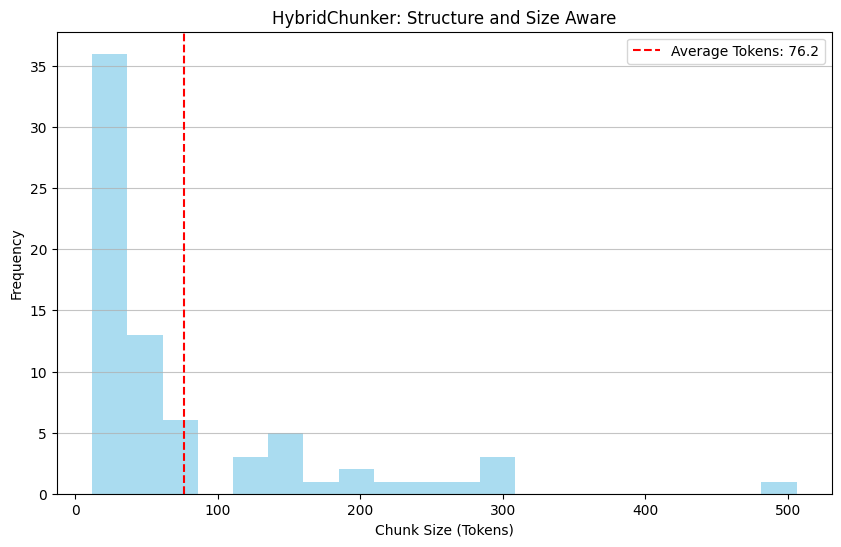

Chunk Analysis Results:
Total chunks: 73
Average chunk size: 76.2 tokens
Minimum chunk size: 12 tokens
Maximum chunk size: 506 tokens
Standard deviation: 91.4 tokens

Reference - Average character length per chunk: 293.2 characters


In [28]:
hybrid_chunker = HybridChunker(tokenizer = embeddings_tokenizer)
hybrid_chunks = list(hybrid_chunker.chunk(doc))

print(f'HybridChunker Results: ')
print(f'Generated {len(hybrid_chunks)} chunks')

visualize_chunks(
    chunks = hybrid_chunks,
    title = 'HybridChunker: Structure and Size Aware',
    chunker = hybrid_chunker,
    tokenizer = embeddings_tokenizer
    )

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Advanced Chunker Results: 
Generated 146 chunks with max_tokens = 64


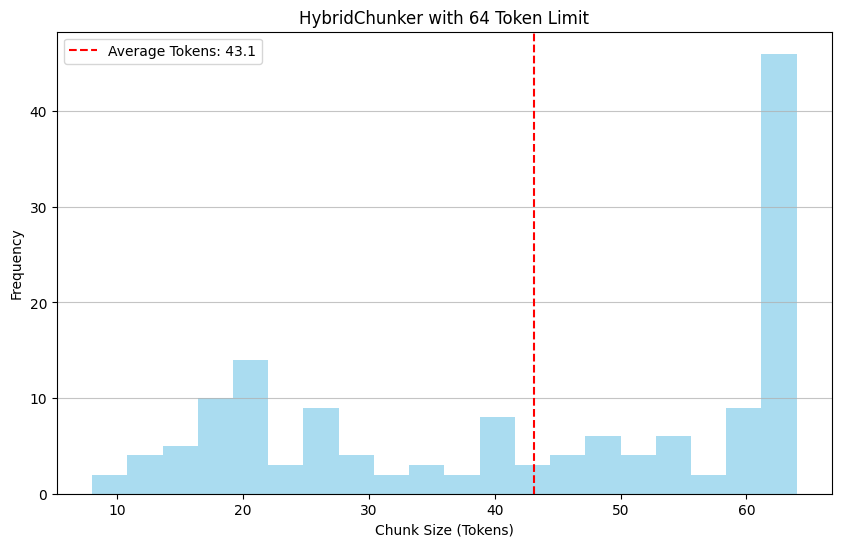

Chunk Analysis Results:
Total chunks: 146
Average chunk size: 43.1 tokens
Minimum chunk size: 8 tokens
Maximum chunk size: 64 tokens
Standard deviation: 18.9 tokens

Reference - Average character length per chunk: 146.1 characters


In [ ]:
max_tokens = 128

adv_tokenizer = HuggingFaceTokenizer(tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path),
                                     max_tokens = max_tokens)
adv_chunker = HybridChunker(tokenizer = adv_tokenizer)
adv_chunks = list(adv_chunker.chunk(doc))

print(f'Advanced Chunker Results: ')
print(f'Generated {len(adv_chunks)} chunks with max_tokens = {max_tokens}')

visualize_chunks(
    chunks = adv_chunks,
    title = f'HybridChunker with {max_tokens} Token Limit',
    chunker = adv_chunker,
    tokenizer = adv_tokenizer
    )

In [ ]:
# Demonstrate contextualization - how chunks get additional context
print(f"\n Understanding Contextualization:")
print(f"Contextualization adds relevant surrounding information to improve retrieval quality.\n")

for i, chunk in enumerate(adv_chunks[:5]):
    tokens_text = adv_tokenizer.count_tokens(chunk.text)
    contextualized = adv_chunker.contextualize(chunk)
    tokens_contextualized = adv_tokenizer.count_tokens(contextualized)

    print(f"Chunk {i}:")
    print(f"Original text ({tokens_text} tokens): {chunk.text[:100]}...")
    print(f"Contextualized ({tokens_contextualized} tokens): {contextualized[:100]}...")
    print(f"Context added: {tokens_contextualized - tokens_text} tokens\n")